# CIAO AO Explanation and Validation

In this notebook we explain and validate several aspects of CIAO's closed-loop operation. We start by validating the loop, by comparing CIAO's calculations with explicit calculations. Second, we validate CIAO's poke matrix methods by explicitly computing a poke matrix. Finally, we explain and validate the wavefront and residual error calculations.

## Explaining and validating the AO loop

Let's start by importing the CIAO modules and config files, as well as the scientific stack. Then we run the simulation check that is executed at the top of every CIAO script.

In [1]:
import sys,os
import ciao_config as ccfg
import ciao
from matplotlib import pyplot as plt
import numpy as np




No module named pypylon
No module named ximea
[Errno 17] File exists: '.gui_settings'


In [2]:
if ccfg.simulate:
    sim = ciao.simulator.Simulator()
    cam = sim
    mirror = cam
else:
    cam = ciao.cameras.get_camera()
    mirror = ciao.mirrors.Mirror()
    
sensor = ciao.sensors.Sensor(cam)

if ccfg.simulate:
    # required to remove tip/tilt in simulated image
    sensor.record_reference()


Loading cached actuator basis set...
Loading cached zernike basis set...
recording reference
sensor paused
measurement 1 of 10 Sensor sense method
start -> cam.get_image: 78.725 ms
cam.get_image -> image stats: 0.561 ms
image stats -> estimate background: 0.170 ms
estimate background -> centroid: 0.645 ms
centroid -> reconstruct wavefront: 0.185 ms
reconstruct wavefront -> end sense: 0.002 ms

...done
measurement 2 of 10 Sensor sense method
start -> cam.get_image: 76.491 ms
cam.get_image -> image stats: 0.564 ms
image stats -> estimate background: 0.167 ms
estimate background -> centroid: 0.656 ms
centroid -> reconstruct wavefront: 0.183 ms
reconstruct wavefront -> end sense: 0.001 ms

...done
measurement 3 of 10 Sensor sense method
start -> cam.get_image: 75.136 ms
cam.get_image -> image stats: 0.568 ms
image stats -> estimate background: 0.172 ms
estimate background -> centroid: 0.666 ms
centroid -> reconstruct wavefront: 0.186 ms
reconstruct wavefront -> end sense: 0.001 ms

...done

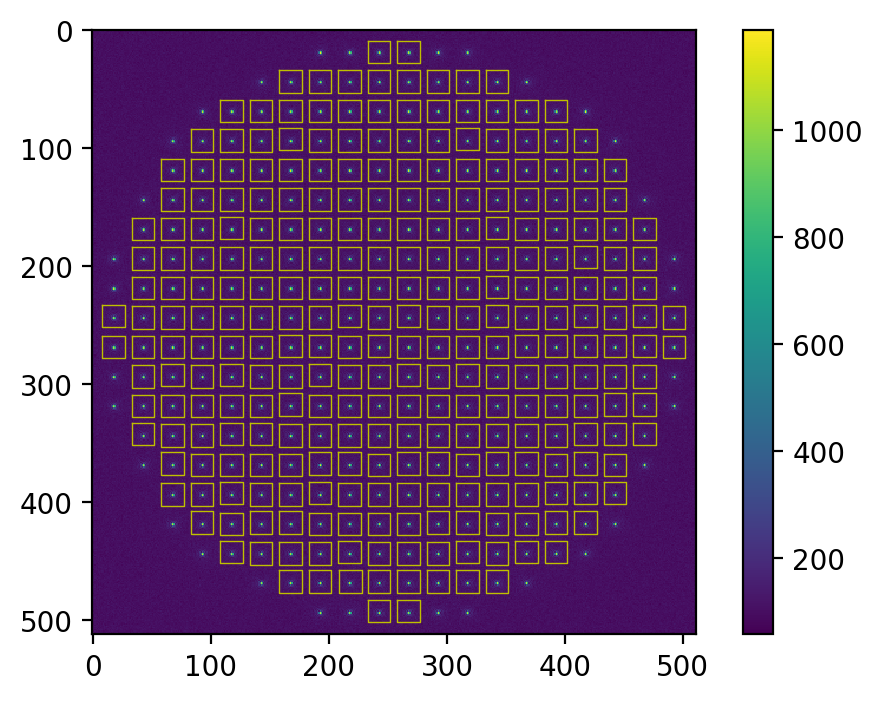

In [3]:
plt.figure(dpi=200)
plt.imshow(cam.get_image())
plt.colorbar()
plt.autoscale(False)
for y1,y2,x1,x2 in zip(sensor.search_boxes.y1,
                       sensor.search_boxes.y2,
                       sensor.search_boxes.x1,
                       sensor.search_boxes.x2):
    plt.plot([x1,x2-1,x2-1,x1,x1],[y1,y1,y2-1,y2-1,y1],'y-',linewidth=.5)

In [4]:
sensor.sense()

Sensor sense method
start -> cam.get_image: 77.960 ms
cam.get_image -> image stats: 0.588 ms
image stats -> estimate background: 0.183 ms
estimate background -> centroid: 0.729 ms
centroid -> reconstruct wavefront: 0.200 ms
reconstruct wavefront -> end sense: 0.001 ms



## Centroiding

Now we define the centroiding method explicitly (as opposed to calling CIAO's built-in method. This allows us to see the iterative centroiding algorithm in detail, including the background subtraction step. It also allows us to check the validity of CIAO's output.

In [12]:
n_iterations = ccfg.centroiding_iterations
half_width= ccfg.search_box_half_width
iterative_step = ccfg.iterative_centroiding_step



# an explicit background estimation function
# whenever we specify the edges of a region with x1,x2,y1,y2, as
# a convention we mean x2 and y2 to be the final column and row in
# the region, as opposed to the python idiom making them the first
# excluded indices
# IMPORTANT: unlike normal Python idiom, y2-y1 no longer indicates
# the number of rows, but one less than that number.
def estimate_background(spots,x_ref,y_ref,half_width,do_plots=False):
    
    if do_plots:
        plt.figure(dpi=200)
        colors = 'gyrm'*100
    
    # half_width and iterative step should be whole numbers
    assert half_width%1==0
    
    # let's enforce the half width being an integer, so that we
    # keep our array indices x1,x2,y1,y2 as integers as well
    half_width = int(half_width)
    
    # we round the reference coordinates to the nearest integer
    # so that we compute the center of mass over whole pixels;
    # an alternative would be linear interpolation, which would be
    # computationally cheap but the code would become complicated
    # make sure these are ints too
    x,y = int(round(x_ref)),int(round(y_ref))
        
    # now we have the (inclusive) column and row indices, all ints
    x1 = x - half_width
    x2 = x + half_width
    y1 = y - half_width
    y2 = y + half_width
    
    
    # first, survey edges to estimate background
    intensity = np.float64(0.0)
    counter = np.float64(0.0)
    
    for xedge in range(x1,x2+1):
        intensity = intensity + float(spots[y1,xedge]) + float(spots[y2,xedge])
        counter = counter + 2.0
        
    for yedge in range(y1,y2+1):
        intensity = intensity + float(spots[yedge,x1]) + float(spots[yedge,x2])
        counter = counter + 2.0

    background = intensity/counter
    
    return background


# an explicit centroiding function
# whenever we specify the edges of a region with x1,x2,y1,y2, as
# a convention we mean x2 and y2 to be the final column and row in
# the region, as opposed to the python idiom making them the first
# excluded indices
# IMPORTANT: unlike normal Python idiom, y2-y1 no longer indicates
# the number of rows, but one less than that number.
def centroid(spots,x_ref,y_ref,half_width,n_iterations,iterative_step,background,do_plots=False):
    
    if do_plots:
        plt.figure(dpi=200)
        colors = 'gyrm'*100
    
    # half_width and iterative step should be whole numbers
    assert half_width%1==0
    assert iterative_step%1==0
    
    # let's enforce the half width being an integer, so that we
    # keep our array indices x1,x2,y1,y2 as integers as well
    half_width = int(half_width)
    iterative_step = int(iterative_step)
    
    # we round the reference coordinates to the nearest integer
    # so that we compute the center of mass over whole pixels;
    # an alternative would be linear interpolation, which would be
    # computationally cheap but the code would become complicated
    # make sure these are ints too
    x,y = int(round(x_ref)),int(round(y_ref))
            
    for k in range(n_iterations):
        x1 = x - half_width
        x2 = x + half_width
        y1 = y - half_width
        y2 = y + half_width
        
        arr = spots[y1:y2+1,x1:x2+1]-background # again, we need the +1 because of Python exclusive indexing
        ay,ax = arr.shape
        if k==0:
            # sanity check
            assert ax==ay==half_width*2+1
            
        XX,YY = np.meshgrid(np.arange(ax),np.arange(ay))        
        XX = XX + x - half_width
        YY = YY + y - half_width
        
        # the spots image is an int, but now
        # we need floating point precision, so convert these to
        # floats
        x_cent = np.sum(XX*arr).astype(np.float)/np.sum(arr).astype(np.float)
        y_cent = np.sum(YY*arr).astype(np.float)/np.sum(arr).astype(np.float)
        x,y = int(round(x_cent)),int(round(y_cent))
        half_width = half_width - iterative_step

        if do_plots:

            if k==0:
                plt.imshow(spots,cmap='gray')
                plt.xlim([x1-1.5,x2+1.5])
                plt.ylim([y2+1.5,y1-1.5])
                plt.colorbar()
                
            plt.plot([x1-.5,x2+.5,x2+.5,x1-.5,x1-.5],[y1-.5,y1-.5,y2+.5,y2+.5,y1-.5],'%s-'%colors[k])
            plt.autoscale(False)
            plt.plot(x_cent,y_cent,'%s.'%colors[k])
            
    return x_cent,y_cent,background
        

### An example of the centroiding process

If we call ```centroid``` with do_plots=True, we'll see the result of the algorithm on a single spot. The green line shows the region used to compute the first iteration, and the yellow line the second iteration. The resulting centroids are plotted as green and yellow dots, respectively.

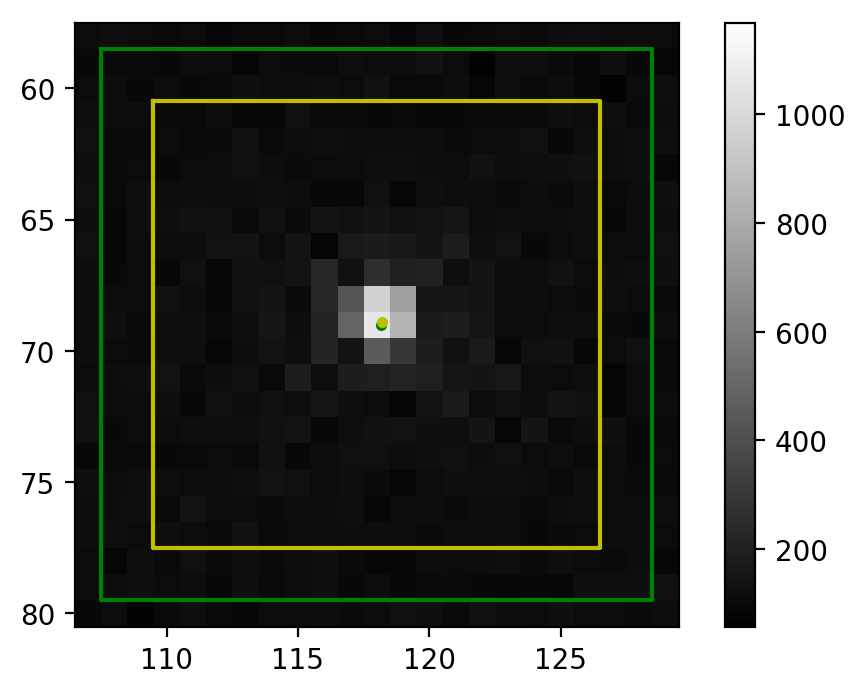

In [18]:
idx=10
x_float = sensor.search_boxes.x[idx]
y_float = sensor.search_boxes.y[idx]

x_cent,y_cent,background = centroid(sensor.cam.image,x_float,y_float,half_width,n_iterations,iterative_step,do_plots=True)    

Sensor sense method
start -> cam.get_image: 80.201 ms
cam.get_image -> image stats: 0.568 ms
image stats -> estimate background: 0.174 ms
estimate background -> centroid: 0.699 ms
centroid -> reconstruct wavefront: 0.190 ms
reconstruct wavefront -> end sense: 0.001 ms



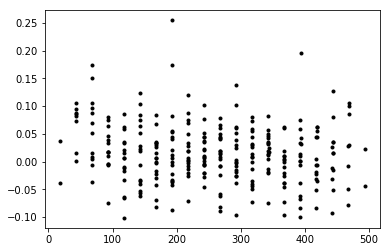

In [23]:
sensor.sense()
x_cent_vec = []
for k_lenslet in range(sensor.n_lenslets):
    x_float = sensor.search_boxes.x[k_lenslet]
    y_float = sensor.search_boxes.y[k_lenslet]
    x_cent,y_cent,bg = centroid(sensor.cam.image,x_float,y_float,half_width,n_iterations,iterative_step,do_plots=False)
    #print sensor.box_backgrounds[k_lenslet],bg
    x_cent_vec.append(x_cent)
    
plt.plot(sensor.x_centroids, x_cent_vec-sensor.x_centroids,'k.')
plt.show()

In [25]:
def centroid_cython(spots_image,
                  x_ref,
                  y_ref,
                  sb_half_width,
                  iterations,
                  iteration_step_px):


    sy = spots_image.shape[0]
    sx = spots_image.shape[1]

    # Populate x_out,y_out with the sb centers, for starters; this allows
    # us to use the out arrays as places to both read the current sb center
    # (in the case of multiple iterations, where we want to recenter the
    # sb on each iteration
    # This serves an additional purpose--preventing sb_x_vec or sb_y_vec from
    # being altered; this is critical, as these represent the loop's search box
    # centers and reference coordinates.
    x_out = x_ref
    y_out = y_ref
    
    # first, we iterate through the number of iterations
    for k_iteration in range(0,iterations):

        imin = 2**15
        imax = -2**15
        xprod = 0.0
        yprod = 0.0
        intensity = 0.0
        counter = 0.0

        x1 = int(round(x_out))-sb_half_width+k_iteration*iteration_step_px
        x2 = int(round(x_out))+sb_half_width-k_iteration*iteration_step_px
        y1 = int(round(y_out))-sb_half_width+k_iteration*iteration_step_px
        y2 = int(round(y_out))+sb_half_width-k_iteration*iteration_step_px

        background = sb_bg_vec
        #printf("background=%0.1f\n",background)

        for x in range(x1,x2+1):
            for y in range(y1,y2+1):

                # not sure if it's better to cast with python's float()
                # or c's <float>:
                pixel = float(spots_image[y,x])-background

                if pixel<0.0:
                    pixel = 0.0
                xprod = xprod + pixel*x
                yprod = yprod + pixel*y
                intensity = intensity + pixel
                if pixel<imin:
                    imin = pixel
                elif pixel>imax:
                    imax = pixel
                counter = counter + 1.0

        if intensity==0 or xprod==0 or yprod==0:
            printf("Warning: search box intensity low; skipping.\n")
            continue

        mean_intensity = intensity/counter
        maximum_intensity = imax
        minimum_intensity = imin
        x_out = xprod/intensity
        y_out = yprod/intensity
